Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:59:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.7}

XGBoost classification report (test):
              precision    recall  f1-score   support

           0      0.862     0.832     0.847       113
           1      0.627     0.681     0.653        47

    accuracy                          0.787       160
   macro avg      0.745     0.756     0.750       160
weighted avg      0.793     0.787     0.790       160

XGBoost confusion matrix (test):
[[94 19]
 [15 32]]

XGBoost ROC–AUC (test): 0.866

XGBoost feature importances:
region_Northeast              0.179
mean_evi_growing_season       0.097
mean_temperature_c            0.093
longitude                     0.060
elevation_m                   0.054
max_evi_growing_season        0.051
slope_degrees                 0.050
peak_growth_rainfall_mm       0.050
annual_rainfall_mm            0.049
water_occurrence_max_pct      0.048


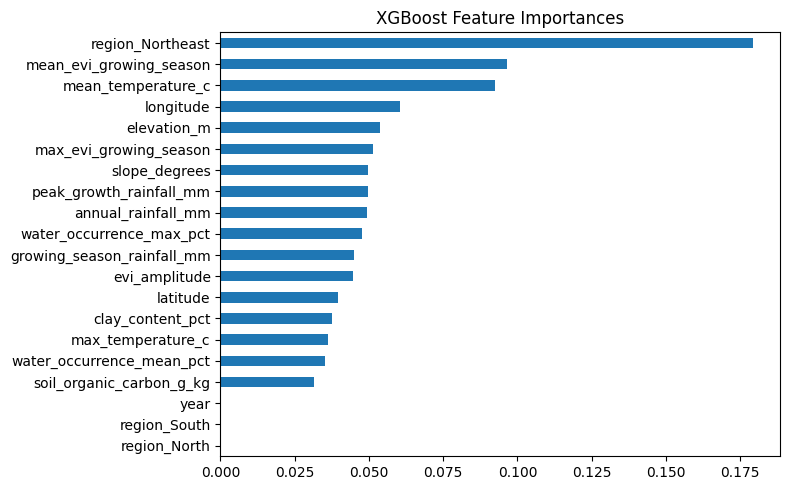

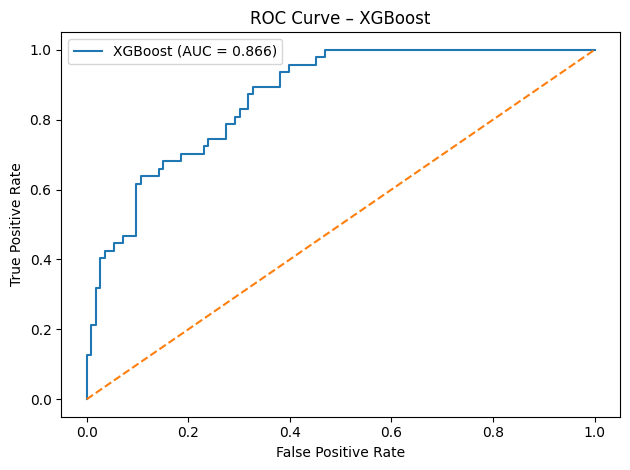

In [ ]:
# If not already installed
!pip -q install xgboost

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel("/content/thailand_riceland_gee_data-6.csv.xlsx")
X = df.drop("is_rice", axis=1)
y = df["is_rice"]
X = X.drop("point_id", axis=1)
X = pd.get_dummies(X, columns=["region"], drop_first=True)
features = X.columns.tolist()

# Split data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model (binary rice / non-rice)
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    tree_method="hist",
    use_label_encoder=False
)

param_dist = {
    "n_estimators":    [100, 200, 300],
    "max_depth":       [3, 4, 5, 6],
    "learning_rate":   [0.03, 0.05, 0.1],
    "subsample":       [0.7, 0.9, 1.0],
    "colsample_bytree":[0.7, 0.9, 1.0],
    "min_child_weight":[1, 3, 5],
    "gamma":           [0, 0.5, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_tr, y_tr)

best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)

#Evaluation on test set
y_pred_xgb  = best_xgb.predict(X_te)
y_proba_xgb = best_xgb.predict_proba(X_te)[:, 1]

print("\nXGBoost classification report (test):")
print(classification_report(y_te, y_pred_xgb, digits=3))

print("XGBoost confusion matrix (test):")
print(confusion_matrix(y_te, y_pred_xgb))

auc_xgb = roc_auc_score(y_te, y_proba_xgb)
print(f"\nXGBoost ROC–AUC (test): {auc_xgb:.3f}")

#Feature importances
imp_xgb = pd.Series(best_xgb.feature_importances_, index=features).sort_values(ascending=False)
print("\nXGBoost feature importances:")
print(imp_xgb.round(3))

#Plot
plt.figure(figsize=(8, 5))
imp_xgb.sort_values().plot(kind="barh")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

#ROC curve
fpr, tpr, _ = roc_curve(y_te, y_proba_xgb)
plt.figure()
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best RandomForest params: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 12, 'bootstrap': True}

RandomForest classification report (test):
              precision    recall  f1-score   support

           0      0.853     0.770     0.809       113
           1      0.552     0.681     0.610        47

    accuracy                          0.744       160
   macro avg      0.702     0.725     0.709       160
weighted avg      0.764     0.744     0.751       160

RandomForest confusion matrix (test):
[[87 26]
 [15 32]]

RandomForest ROC–AUC (test): 0.859

RandomForest feature importances:
mean_temperature_c            0.214
mean_evi_growing_season       0.208
longitude                     0.105
slope_degrees                 0.068
evi_amplitude                 0.067
max_temperature_c             0.051
max_evi_growing_season        0.049
latitude                      0.044

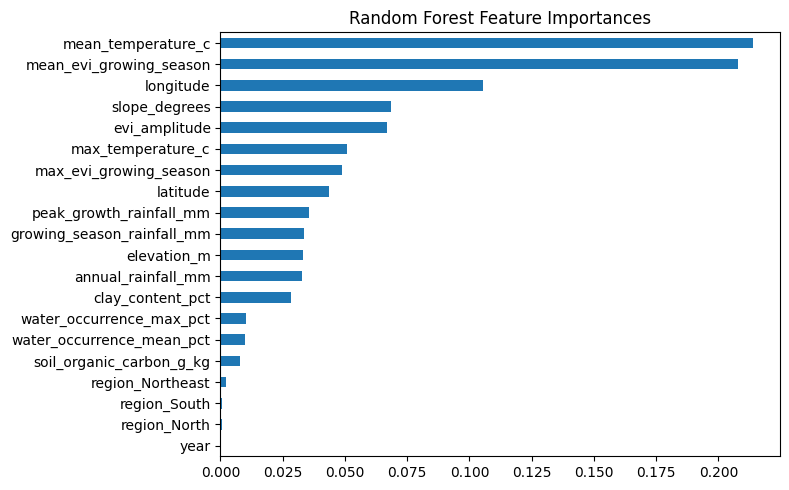

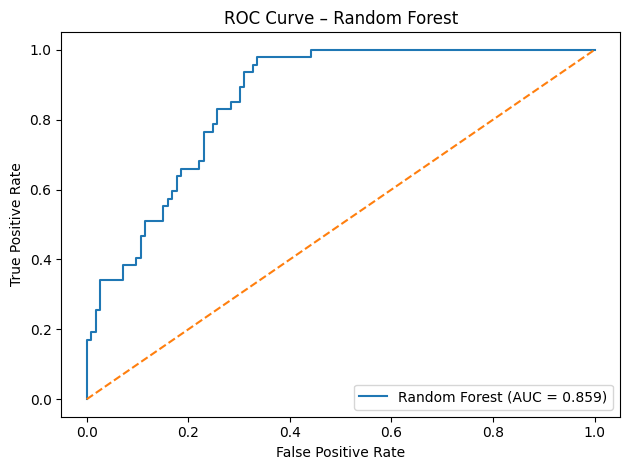

In [ ]:
# If needed in fresh envs (matplotlib/sklearn are usually present)
# !pip -q install matplotlib scikit-learn pandas openpyxl

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

df = pd.read_excel("/content/thailand_riceland_gee_data-6.csv.xlsx")

for maybe_id in ["point_id", "Point_ID", "POINT_ID"]:
    if maybe_id in df.columns:
        df = df.drop(maybe_id, axis=1)

if "is_rice" not in df.columns:
    raise ValueError("Target column 'is_rice' not found in dataset.")
y = df["is_rice"].astype(int)

X = df.drop("is_rice", axis=1)
if "region" in X.columns:
    X = pd.get_dummies(X, columns=["region"], drop_first=True)

features = X.columns.tolist()

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_base = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators":     [200, 400, 600, 800],
    "max_depth":        [None, 6, 8, 12, 16],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features":     ["sqrt", "log2", 0.5, 0.8],
    "bootstrap":        [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_tr, y_tr)
best_rf = rf_search.best_estimator_
print("Best RandomForest params:", rf_search.best_params_)

y_pred_rf  = best_rf.predict(X_te)
y_proba_rf = best_rf.predict_proba(X_te)[:, 1]

print("\nRandomForest classification report (test):")
print(classification_report(y_te, y_pred_rf, digits=3))

print("RandomForest confusion matrix (test):")
print(confusion_matrix(y_te, y_pred_rf))

auc_rf = roc_auc_score(y_te, y_proba_rf)
print(f"\nRandomForest ROC–AUC (test): {auc_rf:.3f}")

imp_rf = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nRandomForest feature importances:")
print(imp_rf.round(3))

# Plot importances
plt.figure(figsize=(8, 5))
imp_rf.sort_values().tail(25).plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

#ROC Curve
fpr, tpr, _ = roc_curve(y_te, y_proba_rf)
plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Logistic Regression params: {'logreg__class_weight': 'balanced', 'logreg__C': np.float64(7.742636826811277)}

Logistic Regression accuracy (test): 0.756
Logistic Regression ROC–AUC (test): 0.869

Logistic Regression classification report (test):
              precision    recall  f1-score   support

           0      0.951     0.690     0.800       113
           1      0.551     0.915     0.688        47

    accuracy                          0.756       160
   macro avg      0.751     0.803     0.744       160
weighted avg      0.834     0.756     0.767       160

Logistic Regression confusion matrix (test):
[[78 35]
 [ 4 43]]


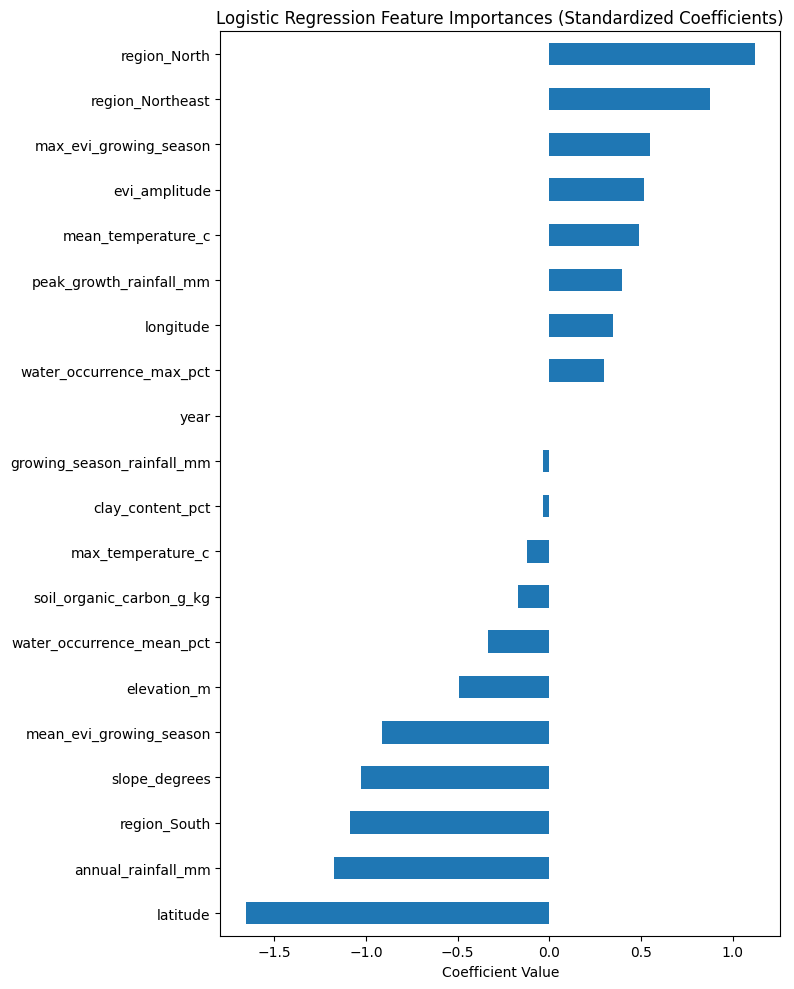

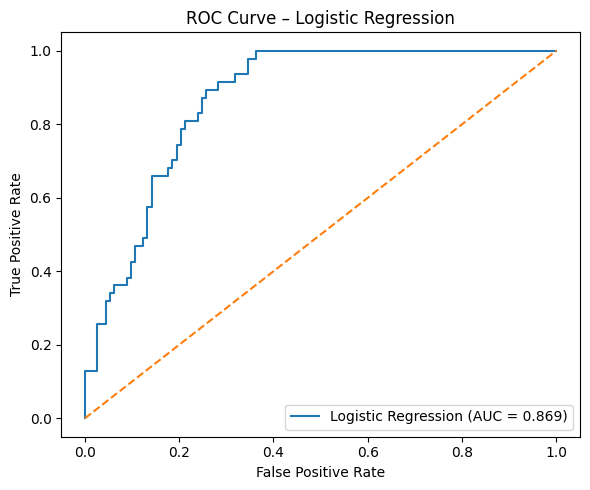

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score
)

df = pd.read_excel("/content/thailand_riceland_gee_data-6.csv.xlsx")

X = df.drop("is_rice", axis=1)
y = df["is_rice"]

X = X.drop("point_id", axis=1)
X = pd.get_dummies(X, columns=["region"], drop_first=True)
features = X.columns.tolist()

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

logit_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])

param_dist_logit = {
    "logreg__C": np.logspace(-3, 2, 10),
    "logreg__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_search = RandomizedSearchCV(
    estimator=logit_pipe,
    param_distributions=param_dist_logit,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

logreg_search.fit(X_tr, y_tr)

best_logreg_pipe = logreg_search.best_estimator_
print("Best Logistic Regression params:", logreg_search.best_params_)

y_pred_logit  = best_logreg_pipe.predict(X_te)
y_proba_logit = best_logreg_pipe.predict_proba(X_te)[:, 1]

acc_logit = accuracy_score(y_te, y_pred_logit)
auc_logit = roc_auc_score(y_te, y_proba_logit)

print(f"\nLogistic Regression accuracy (test): {acc_logit:.3f}")
print(f"Logistic Regression ROC–AUC (test): {auc_logit:.3f}\n")

print("Logistic Regression classification report (test):")
print(classification_report(y_te, y_pred_logit, digits=3))

print("Logistic Regression confusion matrix (test):")
print(confusion_matrix(y_te, y_pred_logit))


fitted_logreg = best_logreg_pipe.named_steps["logreg"]
coef_logit = fitted_logreg.coef_[0]

importance_series = pd.Series(coef_logit, index=features).sort_values()

plt.figure(figsize=(8, 10))
importance_series.plot(kind="barh")
plt.title("Logistic Regression Feature Importances (Standardized Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_te, y_proba_logit)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_logit:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()
